# NLP Twitter with disasters

### Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

In [3]:
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

unable to import 'smart_open.gcs', disabling that module
Using TensorFlow backend.


## load the data

In [4]:
train= pd.read_csv('C:/Users/zjx_n/Desktop/labs/NLP with disasters/nlp-getting-started/train.csv')
test=pd.read_csv('C:/Users/zjx_n/Desktop/labs/NLP with disasters/nlp-getting-started/test.csv')
submission = pd.read_csv('C:/Users/zjx_n/Desktop/labs/NLP with disasters/nlp-getting-started/sample_submission.csv')

In [5]:
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [6]:
print('There are {} rows and {} columns in train.csv'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test.csv'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train.csv
There are 3263 rows and 4 columns in test.csv


## Basic EDAs

In statistics, exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. 

### Missing values

In [7]:
# Missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
# Missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

A lot of values are missing in the location column in both the training and the testing set.

In [9]:
# Creating bool series True for NAN values for location
bool_series_location = pd.isnull(train['location'])
lengthNull = len(train[bool_series_location])
print("Number of records with missing location is ",lengthNull)

Number of records with missing location is  2533


In [10]:
# Creating bool series True for NAN values
bool_series_keyword = pd.isnull(train['keyword'])
lengthNullKeyword  = len(train[bool_series_keyword])
print("Number of records with missing keywords is",lengthNullKeyword)

Number of records with missing keywords is 61


In [11]:
#Calcalate percentage of missing keywords
print('{}% Keywords are missing from total number of records'.format((len(train[bool_series_keyword])/len(train.index))*100))

0.8012610009194797% Keywords are missing from total number of records


Locations are not automatically generated, they are user inputs and that's why data is not clean and there are too many incoorect and missing values.We can skip the 'location' column from our feature list

We can consider the 'keyword' column as a feature because there are a lot of unique keywords and missing values are very insignificant (< 1 percentage)

## target distribution

First we should check the target distribution.

We have predict whether a given tweet ia about a real disaster or not. If so, predict 1, if not, predict a 0.

In [12]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

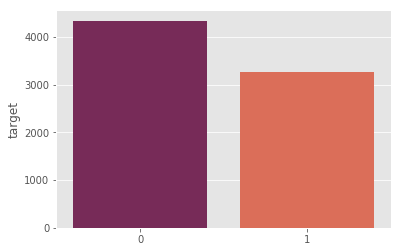

In [13]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts(),palette = 'rocket')

In [14]:
# extracting number of examples of each class
Real_len = train[train['target'] == 1].shape[0]
Not_len = train[train['target'] == 0].shape[0]
print(Real_len,Not_len)

3271 4342


Let us see how often thr word 'disaster' come in the dataset and whether this help us in determing whether a tweet belongs to a disaster category or not

In [15]:
train.loc[train['text'].str.contains('disaster',na=False,case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

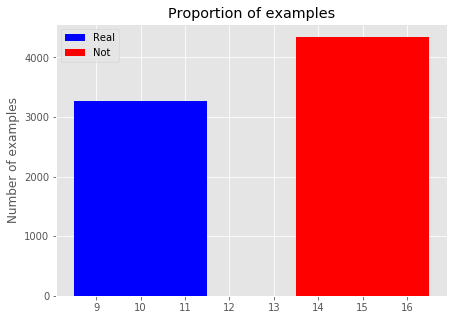

In [16]:
# bar plot of 3 classes
plt.rcParams['figure.figsize'] = (7,5)
plt.bar(10,Real_len,3,label = "Real", color = 'blue')
plt.bar(15,Not_len,3,label = "Not",color = 'red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

In [17]:
def length(text):
    return len(text)

In [18]:
train['length'] = train['text'].apply(length)
train.head(10)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5   8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6  10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7  13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8  14     NaN      NaN  There's an emergency evacuation happening now ...   
9  15     NaN      NaN  I'm afraid that the tornado is coming to our a...   

   target  length  
0       1      69  
1       1      38  
2       1     133  
3       1      65  
4       1      88  
5       1     110  
6       1      95  
7       1      59  
8       1      79  
9       1      52

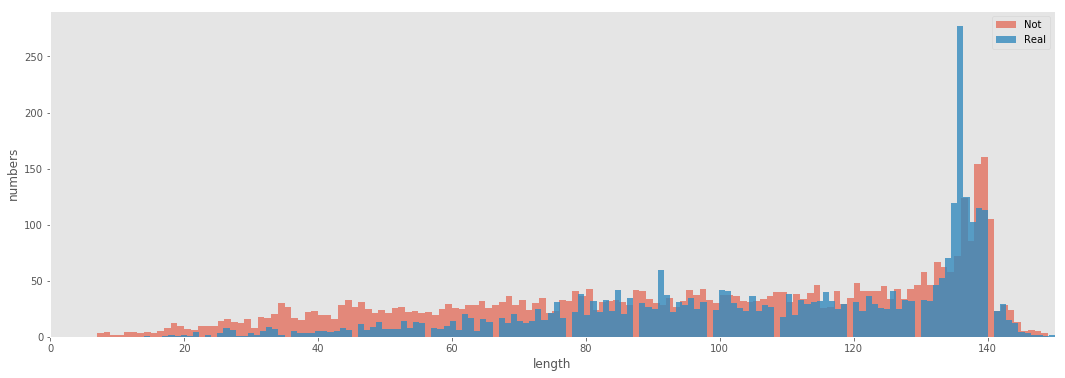

In [19]:
plt.rcParams['figure.figsize'] = (18.0,6.0)
bins = 150
plt.hist(train[train['target'] == 0]['length'],alpha = 0.6, bins = bins, label = 'Not')
plt.hist(train[train['target'] == 1]['length'],alpha = 0.8, bins = bins, label = 'Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc = 'upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

### characters in tweets

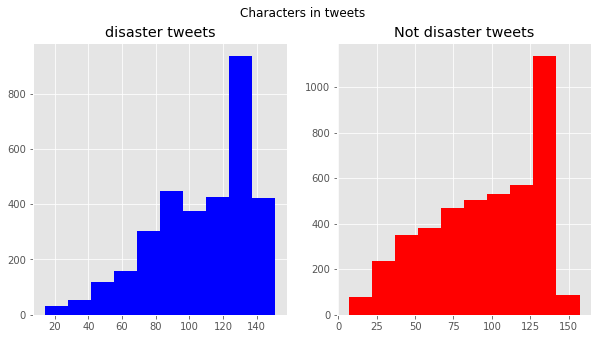

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
tweet_len = train[train['target'] == 1]['text'].str.len()
ax1.hist(tweet_len,color = 'blue')
ax1.set_title('disaster tweets')
tweet_len = train[train['target'] == 0]['text'].str.len()
ax2.hist(tweet_len,color = 'red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

### Average word length in each tweet

Text(0.5, 0.98, 'Average word length in each tweet')

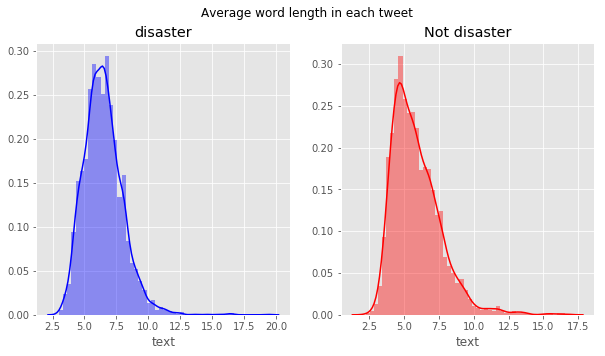

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
word = train[train['target'] == 1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x:np.mean(x)),ax = ax1,color = 'blue')
ax1.set_title('disaster')

word = train[train['target'] == 0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x:np.mean(x)),ax = ax2,color = 'red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

### exploring the 'keyword' column

The keyword column denotes a keyword from the tweet, Let us look at the top 20 keywords in the training data

In [22]:
dist_keyword = train['keyword'].value_counts()
dist_keyword

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

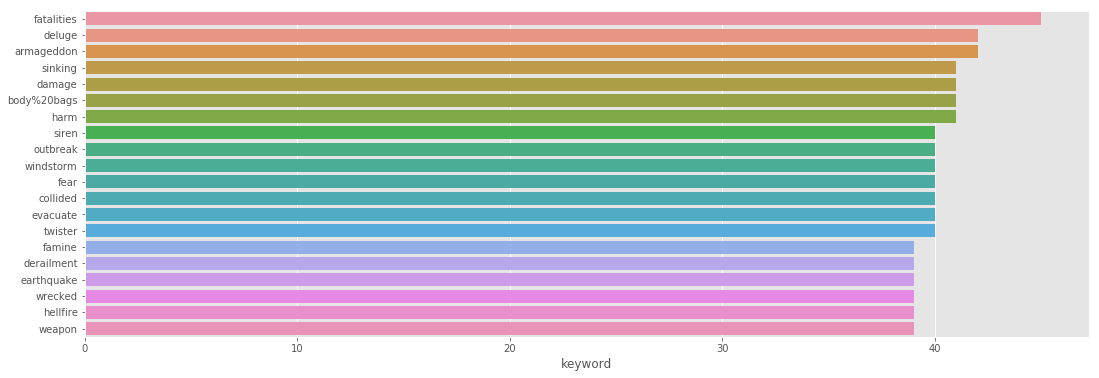

In [23]:
sns.barplot(y=dist_keyword[:20].index,x=dist_keyword[:20],orient='h')

In [24]:
import plotly.express as px

In [25]:
#Visualize the keywords
fig = px.scatter(dist_keyword, x=dist_keyword.values, y=dist_keyword.index,size=dist_keyword.values)
fig.show()

### Exploring the 'location' column

In [26]:
# Distinct location in train dataset
dist_location = train['location'].value_counts()
#print(dist_location)
#Visualize location
fig = px.scatter(dist_location,y=dist_location.values,x=dist_location.index,size=dist_location.values)
fig.show()

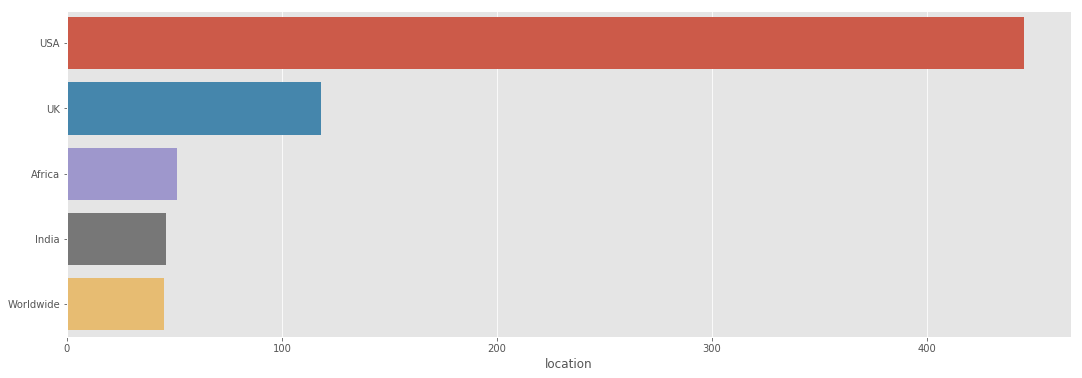

In [27]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')


### common stopwords in tweets

First we will analyze tweets with class 0 which indicates no disasters

In [28]:
def create_corpus(target):
    corpus = []
    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    
    return corpus

In [29]:
corpus = create_corpus(0)

In [30]:
dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(),key = lambda x:x[1],reverse = True)[:10]

In [31]:
top

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442)]

In [32]:
# display the stopwords
np.array(stop)

array({'up', 're', 'no', 'until', "wouldn't", 'here', 't', 'at', "hasn't", 'doing', 'ourselves', 'shan', 'are', 'our', 'same', 'or', 'hadn', 'below', 'such', 'it', "hadn't", "don't", 'am', 'again', 'the', "mightn't", 'by', 'through', 'had', 'from', 'needn', 'd', 'did', 'do', 'its', 'hasn', 'she', 'mustn', 'shouldn', "you'd", "mustn't", "weren't", 'further', 'didn', 'he', 'yourselves', 'other', 'himself', "you'll", 'now', 'but', 'their', 'those', 'a', 'having', 'between', 'to', 'won', 'an', 'before', 'over', 'once', "you've", 'which', 'off', 'myself', 'his', "it's", 'm', 'too', 'that', 'o', 'you', "couldn't", 'above', 'during', 'most', 'out', 'hers', "you're", 'ain', "won't", "isn't", 'of', 'there', 'very', 'theirs', 'yourself', 'these', 'if', 'haven', 'whom', 'being', "aren't", "that'll", 'against', 'y', "wasn't", 'both', 'll', 'not', 'couldn', 'while', 'aren', 'i', 'and', 'about', 've', 'more', 'does', 'because', 'just', 'nor', 'only', "shan't", 'we', 'when', 'than', 'should', 'my', '

<BarContainer object of 10 artists>

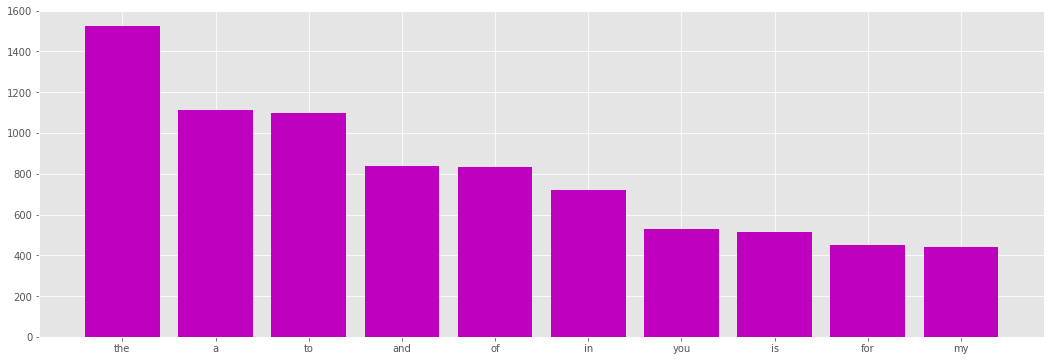

In [33]:
plt.rcParams['figure.figsize'] = (18.0,6.0)
x,y = zip(*top)
plt.bar(x,y,color='m')

Then we will analyze tweets with class 1 which indicates real disasters

In [34]:
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top = sorted(dic.items(),key = lambda x:x[1],reverse=True)[:10]

<BarContainer object of 10 artists>

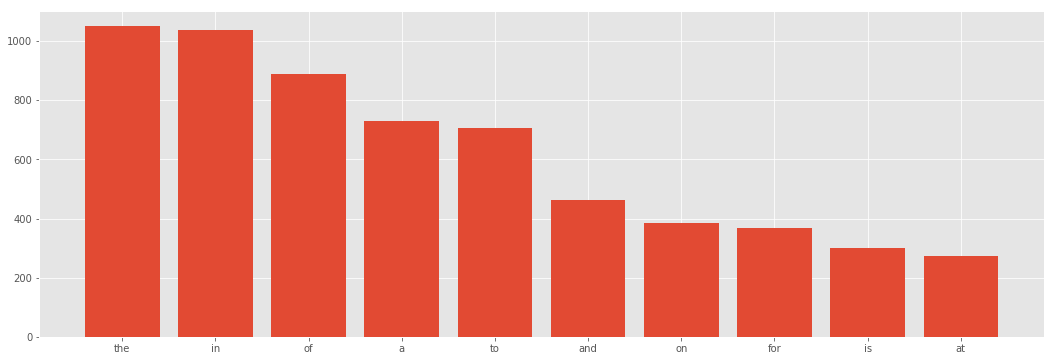

In [35]:
plt.rcParams['figure.figsize'] = (18.0,6.0)
x,y = zip(*top)
plt.bar(x,y)

In both of them, "the" dominates which is followed by "a" in class 0 and "in" class 1.

## Analyzing punctuations

 First we should check tweets with real disasters(target==1) 

<BarContainer object of 18 artists>

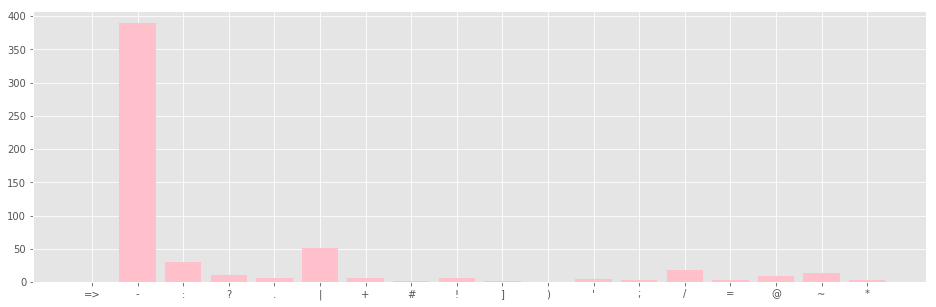

In [36]:
plt.figure(figsize = (16,5))
corpus = create_corpus(1)

dic = defaultdict(int)
special = string.punctuation

for i in corpus:
    if i in special:
        dic[i]+=1
        
x,y = zip(*dic.items())
plt.bar(x,y,color='pink')

Then we will move onto class 0 which indicates no disasters.

<BarContainer object of 20 artists>

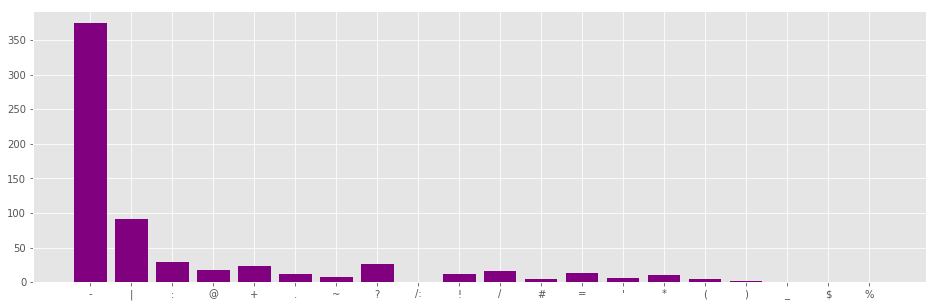

In [37]:
plt.figure(figsize=(16,5))
corpus = create_corpus(0)
dic = defaultdict(int)
special = string.punctuation

for i in (corpus):
    if i in special:
        dic[i]+=1

x,y = zip(*dic.items())
plt.bar(x,y,color='purple')

### common words

In [38]:
plt.figure(figsize=(16,5))
counter = Counter(corpus)
most = counter.most_common()

<Figure size 1152x360 with 0 Axes>

In [39]:
x = []
y = []
for word,count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

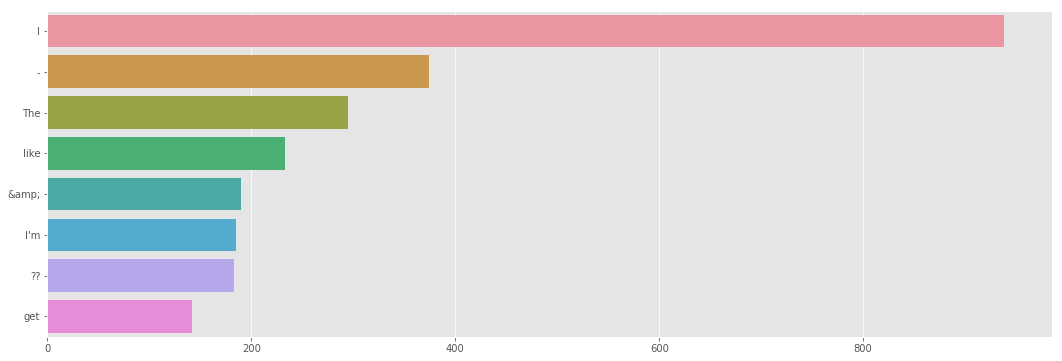

In [40]:
sns.barplot(x=y,y=x)

### unique words

In [41]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

In [42]:
corpus_unique  = []
pstem = PorterStemmer()
for i in range(train['text'].shape[0]):
    #Remove unwanted words
    text = re.sub("[^a-zA-Z]", ' ',train['text'][i])
    #Transform words to lowercase
    text = text.lower()
    text = text.split()
    #Remove stopwords then Stemming it
    text = [pstem.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    #Append cleaned tweet to corpus
    corpus_unique.append(text)
    
print("Corpus_unique created successfully")  

Corpus_unique created successfully


In [43]:
corpus_unique[:20]

['deed reason earthquak may allah forgiv us',
 'forest fire near la rong sask canada',
 'resid ask shelter place notifi offic evacu shelter place order expect',
 'peopl receiv wildfir evacu order california',
 'got sent photo rubi alaska smoke wildfir pour school',
 'rockyfir updat california hwi close direct due lake counti fire cafir wildfir',
 'flood disast heavi rain caus flash flood street manit colorado spring area',
 'top hill see fire wood',
 'emerg evacu happen build across street',
 'afraid tornado come area',
 'three peopl die heat wave far',
 'haha south tampa get flood hah wait second live south tampa gonna gonna fvck flood',
 'rain flood florida tampabay tampa day lost count',
 'flood bago myanmar arriv bago',
 'damag school bu multi car crash break',
 'man',
 'love fruit',
 'summer love',
 'car fast',
 'goooooooaaaaaal']

We will create a dictionary for this where 'key' refers to a word and 'value' refers to frequency of that word in tweets and 
data frame from that dictionary.

In [44]:
# Create dictionary
uniqueWords = {}
for text in corpus_unique:
    for word in text.split():
        if(word in uniqueWords.keys()):
            uniqueWords[word]+=1
        else:
            uniqueWords[word] = 1

In [45]:
#Convert dictionary to dataFrame
uniqueWords = pd.DataFrame.from_dict(uniqueWords,orient='index',columns=['WordFrequency'])
uniqueWords.sort_values(by=['WordFrequency'],inplace=True,ascending=False)
print("Number of records in Unique Words Data Frame are {}".format(len(uniqueWords)))
uniqueWords.head(10)

Number of records in Unique Words Data Frame are 18889


WordFrequency
co             4746
http           4721
like            411
fire            363
amp             344
get             311
bomb            239
new             228
via             220
u               216

In [46]:
#Get Maximum,Minimum and Mean occurance of a word 
print("Maximum Occurance of a word is {} times".format(uniqueWords['WordFrequency'].max()))
print("Minimum Occurance of a word is {} times".format(uniqueWords['WordFrequency'].min()))
print("Mean Occurance of a word is {} times".format(uniqueWords['WordFrequency'].mean()))

Maximum Occurance of a word is 4746 times
Minimum Occurance of a word is 1 times
Mean Occurance of a word is 4.664249033829213 times


In [47]:
uniqueWords = uniqueWords[uniqueWords['WordFrequency']>=20]
print("Number of records in Unique Words Data Frame are {}".format(len(uniqueWords)))

Number of records in Unique Words Data Frame are 787


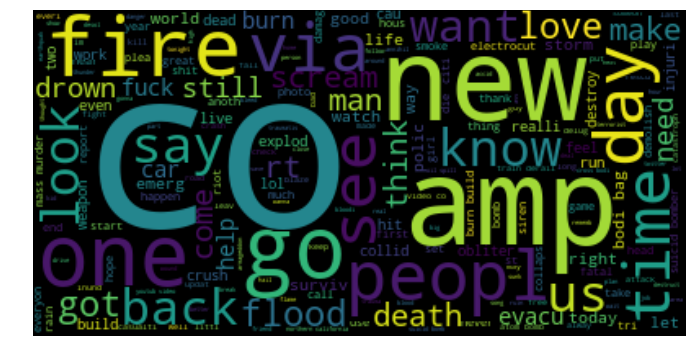

In [48]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(" ".join(corpus_unique))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## N-gram analysis

We will do a biagram (n=2) analysis over the tweets.

In [49]:
def get_top_tweet_bigrams(corpus,n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word,sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse=True)
    return words_freq[:n]

In [50]:
plt.figure(figsize = (16,5))
top_tweet_bigrams = get_top_tweet_bigrams(train['text'])[:10]

<Figure size 1152x360 with 0 Axes>

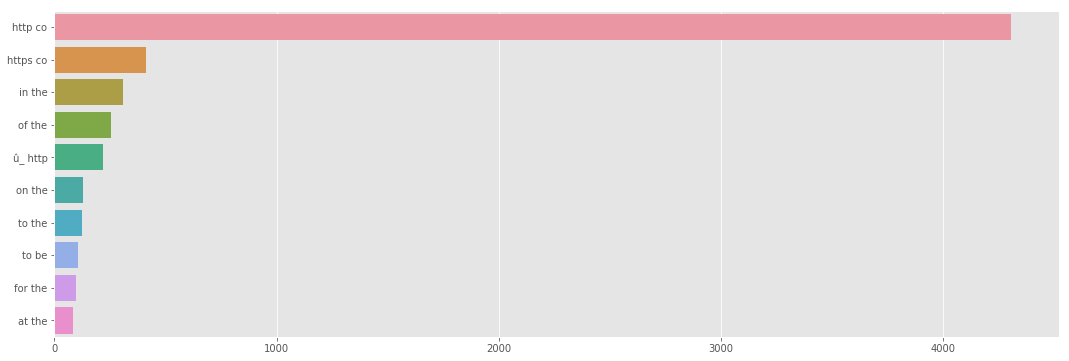

In [51]:
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

## Data Cleaning

In [52]:
df_train = train
df_train.shape

(7613, 6)

In [53]:
df_test = test
df_test.shape

(3263, 4)

### removing urls

In [54]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [55]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [56]:
remove_URL(example)

'New competition launched :'

In [57]:
df_train['text'] = df_train['text'].apply(lambda x:remove_URL(x))

In [58]:
df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  length  
0       1      69  
1       1      38  
2       1     133  
3       1      65  
4       1      88

### removing HTML tags

In [59]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [60]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [61]:
df_train['text'] = df_train['text'].apply(lambda x:remove_html(x))

In [62]:
df_train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610          M1.94 [01:04 UTC]?5km S of Volcano Hawaii. 
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

### removing emojis

In [63]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [64]:
df_train['text'] = df_train['text'].apply(lambda x:remove_emoji(x))

In [65]:
df_train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610          M1.94 [01:04 UTC]?5km S of Volcano Hawaii. 
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

### removing punctuations

In [66]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [67]:
example = "I am a #king"
print(remove_punct(example))

I am a king


In [68]:
df_train['text'] = df_train['text'].apply(lambda x:remove_punct(x))

In [69]:
df_train['text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    ariaahrary TheTawniest The out of control wild...
7610                M194 0104 UTC5km S of Volcano Hawaii 
7611    Police investigating after an ebike collided w...
7612    The Latest More Homes Razed by Northern Califo...
Name: text, Length: 7613, dtype: object

### search real disasters

In [70]:
def create_corpus_df(tweet,target):
    corpus = []
    
    for x in df_train[df_train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    
    return corpus

In [71]:
corpus_new1 = create_corpus_df(df_train,1)
print(len(corpus_new1))

46269


In [72]:
corpus_new1[:10]

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 'earthquake',
 'May',
 'ALLAH']

We will create a dictionary for this where 'key' refer to a word and 'value' refer to frequency of that word in tweets and dataframe from that dictionary.

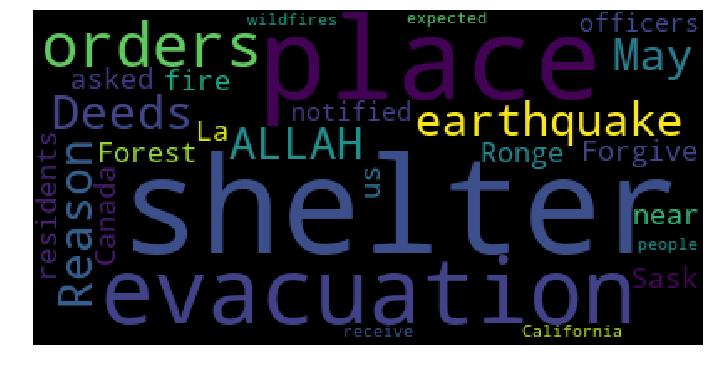

In [73]:
# Generating the worldcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',max_font_size=80).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### search for not disasters

In [74]:
corpus_new0 = create_corpus_df(df_train,0)
print(len(corpus_new0))

60478


In [75]:
corpus_new0[:10]

['Whats', 'up', 'man', 'I', 'love', 'fruits', 'Summer', 'is', 'lovely', 'My']

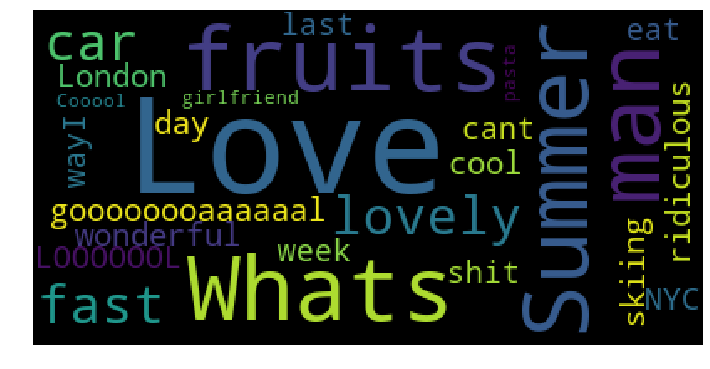

In [76]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize = (12,8))
word_cloud = WordCloud(background_color='black',max_font_size=80).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [77]:
df_train.head(10)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this earthquake Ma...   
1   4     NaN      NaN              Forest fire near La Ronge Sask Canada   
2   5     NaN      NaN  All residents asked to shelter in place are be...   
3   6     NaN      NaN  13000 people receive wildfires evacuation orde...   
4   7     NaN      NaN  Just got sent this photo from Ruby Alaska as s...   
5   8     NaN      NaN  RockyFire Update  California Hwy 20 closed in ...   
6  10     NaN      NaN  flood disaster Heavy rain causes flash floodin...   
7  13     NaN      NaN  Im on top of the hill and I can see a fire in ...   
8  14     NaN      NaN  Theres an emergency evacuation happening now i...   
9  15     NaN      NaN   Im afraid that the tornado is coming to our area   

   target  length  
0       1      69  
1       1      38  
2       1     133  
3       1      65  
4       1      88  
5       1     110  
6       1      95  
7       1      59  
8       1      79  
9       1      52

### Bag of Words Counts

Countvectorizer converts a collection of text documents to a matrix of token counts. It is important to note that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal.

In [78]:
def cv(data):
    count_vectorizer = CountVectorizer()
    
    emb = count_vectorizer.fit_transform(data)
    
    return emb,count_vectorizer

In [79]:
list_corpus = df_train["text"].tolist()
list_labels = df_train["target"].tolist()

In [80]:
list_corpus[:20]

['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask Canada',
 'All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected',
 '13000 people receive wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school ',
 'RockyFire Update  California Hwy 20 closed in both directions due to Lake County fire  CAfire wildfires',
 'flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas',
 'Im on top of the hill and I can see a fire in the woods',
 'Theres an emergency evacuation happening now in the building across the street',
 'Im afraid that the tornado is coming to our area',
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK flooding',
 'raining 

In [81]:
X_train,X_test,y_train,y_test = train_test_split(list_corpus,list_labels,train_size=0.8,random_state = 1)

In [82]:
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)
y_train_counts = y_train
y_test_counts = y_test

In [83]:
def plot_LSA(test_data,test_labels,savepath="PCA_demo.csv",plot=True):
    lsa = TruncatedSVD(n_components = 2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange','blue']
    if plot:
        plt.scatter(lsa_scores[:,0],lsa_scores[:,1],s=8,alpha=.8,c=test_labels,cmap=matplotlib.colors.ListedColormap(colors))
        orange_patch = mpatches.Patch(color='orange',label = 'Not')
        blue_patch = mpatches.Patch(color='blue',label = 'Real')
        plt.legend(handles = [orange_patch,blue_patch],prop = {'size':30})

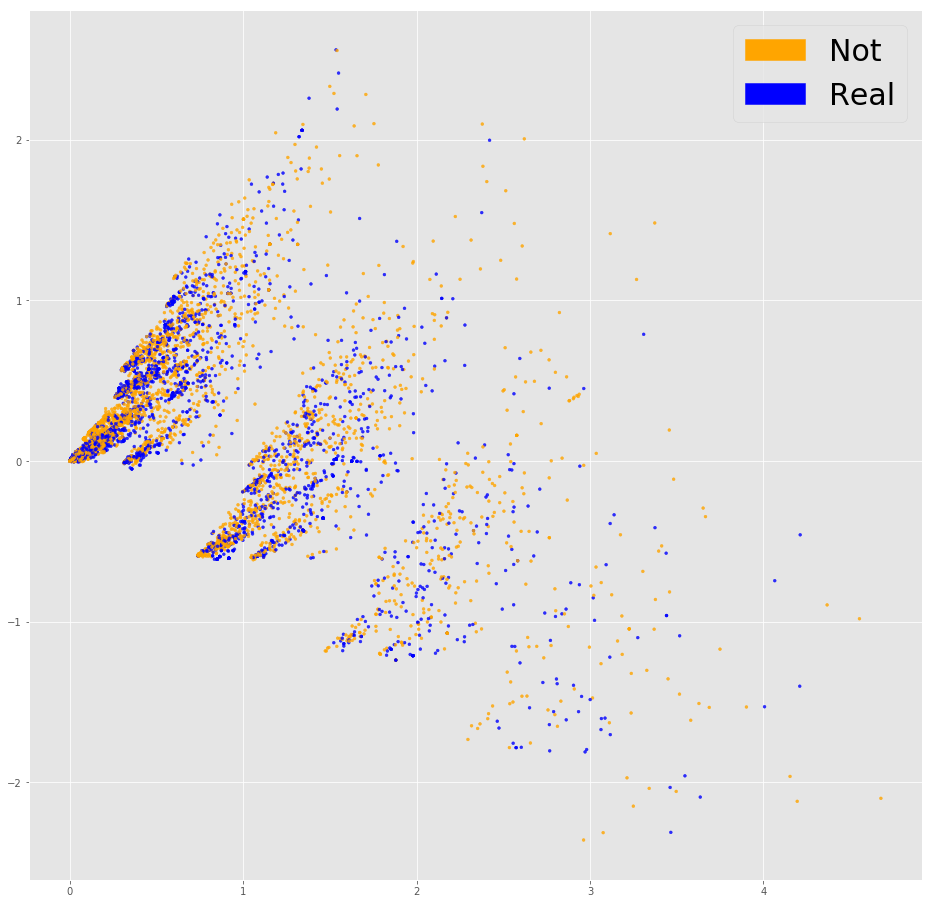

In [84]:
fig = plt.figure(figsize = (16,16))
plot_LSA(X_train_counts,y_train_counts)
plt.show()

These embeddings do not look very cleanly separated. Let us see if we can still fit a useful model on them.

## TFIDF

A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

Term Frequency: is a scoring of the frequency of the word in the current document.

TF = (Number of times term t appears in a document)/(Number of terms in the document)
Inverse Document Frequency: is a scoring of how rare the word is across documents.

IDF = 1+log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

词频（tf）是一词语出现的次数除以该文件的总词语数。
而计算文件频率（IDF）的方法是以文件集的文件总数，除以出现“母牛”一词的文件数。

In [85]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    
    train = tfidf_vectorizer.fit_transform(data)
    
    return train,tfidf_vectorizer

In [86]:
X_train_tfidf,tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_train_tfidf = y_train
y_test_tfidf = y_test

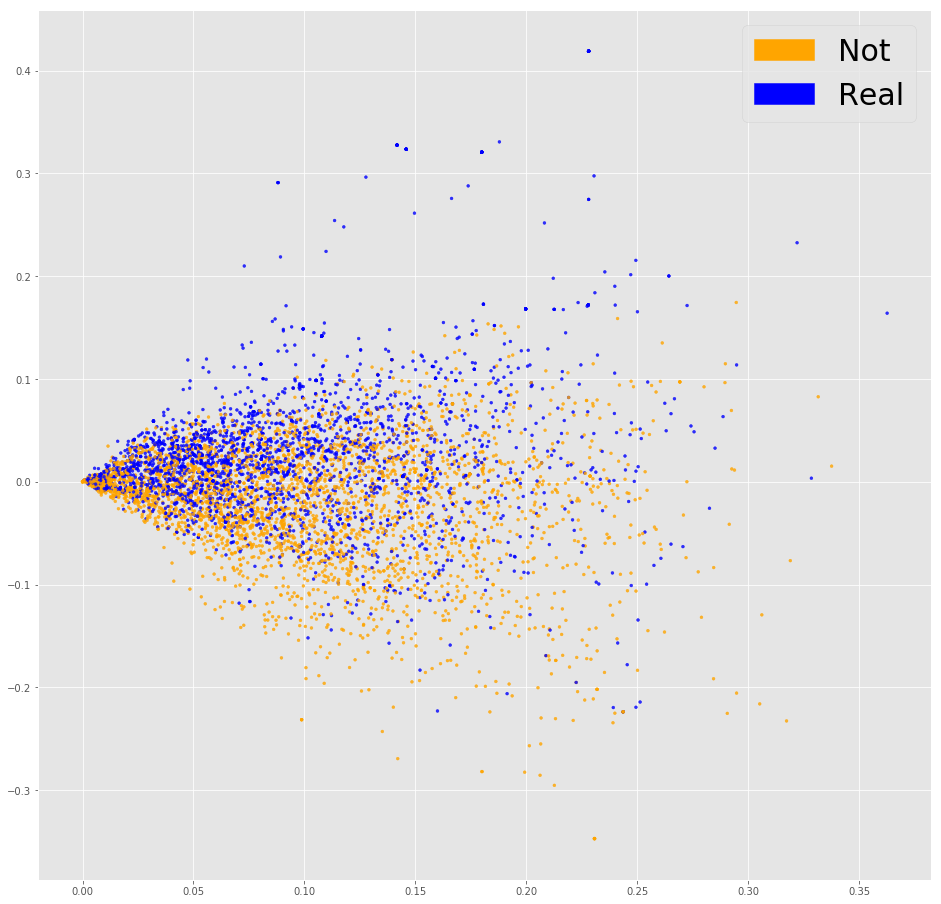

In [87]:
fig = plt.figure(figsize=(16,16))
plot_LSA(X_train_tfidf,y_train_tfidf)
plt.show()

# Build a Text Classification Model

### Confusion Matrix

It is a binary classifier predicts all data instances of a test dataset as either positive or negative.
This classification produces four outcomes - true positive, true negative, false postive and false negative.

True positive (TP): correct positive prediction
False positive (FP): incorrect positive prediction
True negative (TN): correct negative prediction
False negative (FN): incorrect negative prediction

### Logistic Regression Classifier

In [88]:
# Fitting a simple logistic Regression on Counts
clf_lr = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_lr, X_train_counts,y_train_counts,cv=5, scoring="f1")
scores

C:\Users\zjx_n\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



array([0.73899693, 0.7398374 , 0.75151515, 0.75766568, 0.75518672])

In [89]:
clf_lr.fit(X_train_counts,y_train_counts)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
y_pred_lr = clf_lr.predict(X_test_counts)

# Making the Confusion Matrix
cm_lr = confusion_matrix(y_test_counts,y_pred_lr)
cm_lr

array([[770, 112],
       [197, 444]], dtype=int64)

In [91]:
#Calculating Model Accuracy
print('Logistic Regression Model Accuracy Score for Train Data set is {}'.format(clf_lr.score(X_train_counts, y_train_counts)))
print('Logistic Regression Model Accuracy Score for Validation Data set is {}'.format(clf_lr.score(X_test_counts, y_test_counts)))
print('Logistic Regression Model F1 Score is {}'.format(f1_score(y_test_counts, y_pred_lr)))

Logistic Regression Model Accuracy Score for Train Data set is 0.9656814449917899
Logistic Regression Model Accuracy Score for Validation Data set is 0.7971109652002626
Logistic Regression Model F1 Score is 0.7418546365914788


In [92]:
# Fitting a simple Logistic Regression on TFIDF
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf,X_train_tfidf,y_train_tfidf, cv=5, scoring="f1")
scores

C:\Users\zjx_n\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



array([0.74017467, 0.72299465, 0.73144105, 0.73995772, 0.74484256])

It appears the countvectorizer gives a better performance than TFIDF in this case.

### Gaussian Naive Bayes

In [93]:
from sklearn.naive_bayes import GaussianNB

In [94]:
# Fitting Gaussian Naive Bayes to the Training set
classifier_gnb = GaussianNB()
classifier_gnb.fit(X_train_counts.toarray(), y_train_counts)
# Predicting the Train data set results

GaussianNB(priors=None, var_smoothing=1e-09)

In [95]:
y_pred_gnb = classifier_gnb.predict(X_test_counts.toarray())

In [96]:
# Making the Confusion Matrix
cm_gnb = confusion_matrix(y_test_counts, y_pred_gnb)
cm_gnb

array([[432, 450],
       [134, 507]], dtype=int64)

In [97]:
#Calculating Model Accuracy
print('GaussianNB Classifier Accuracy Score is {} for Train Data Set'.format(classifier_gnb.score(X_train_counts.toarray(), y_train_counts)))
print('GaussianNB Classifier Accuracy Score is {} for Validation Data Set'.format(classifier_gnb.score(X_test_counts.toarray(), y_test_counts)))
print('GaussianNB Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_gnb)))

GaussianNB Classifier Accuracy Score is 0.9244663382594417 for Train Data Set
GaussianNB Classifier Accuracy Score is 0.6165462902166776 for Validation Data Set
GaussianNB Classifier F1 Score is 0.6345431789737171


### Naives Bayes Classifier

In [98]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, X_train_counts, y_train_counts, cv=5, scoring="f1")
scores

array([0.76064909, 0.73493976, 0.74170854, 0.74404762, 0.75604839])

In [99]:
clf_NB.fit(X_train_counts,y_train_counts)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [100]:
# Predicting the Train data set results
y_pred_NB = clf_NB.predict(X_test_counts)
# Making the Confusion Matrix
cm_NB = confusion_matrix(y_test_counts, y_pred_NB)
cm_NB

array([[793,  89],
       [200, 441]], dtype=int64)

In [101]:
#Calculating Model Accuracy
print('Naives Bayes Classifier Accuracy Score is {} for Train Data Set'.format(clf_NB.score(X_train_counts, y_train_counts)))
print('Naives Bayes Classifier Accuracy Score is {} for Validation Data Set'.format(clf_NB.score(X_test_counts, y_test_counts)))
print('Naives Bayes Classifier F1 Score is {} '.format(f1_score(y_test_counts, y_pred_NB)))

Naives Bayes Classifier Accuracy Score is 0.906896551724138 for Train Data Set
Naives Bayes Classifier Accuracy Score is 0.8102429415627052 for Validation Data Set
Naives Bayes Classifier F1 Score is 0.7532023911187019 


In [102]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF,X_train_tfidf,y_train_tfidf, cv=5, scoring="f1")
scores

array([0.71011236, 0.71583514, 0.71381215, 0.72747014, 0.72967033])

In [103]:
clf_NB_TFIDF.fit(X_train_tfidf,y_train_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [104]:
# Predicting the Train data set results
y_pred_NB_IDF = clf_NB_TFIDF.predict(X_test_tfidf)

y_pred_DF = pd.DataFrame(y_pred_NB_IDF,columns=['pred_IDF'])

In [105]:
y_pred_DF.head(10)

pred_IDF
0         1
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         1
9         0

It is obvious that Naives Bayes Classifier is better than logistic regression classifier.

### Gradient Boosting Model

In [106]:
from sklearn.ensemble import GradientBoostingClassifier

In [107]:
# Fitting Gradient Boosting Models to the Training set
classifier_gb = GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 100,
                                                   max_depth = 30,
                                                   random_state=55)
classifier_gb.fit(X_train_counts, y_train_counts)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=30,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=55, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [108]:
y_pred_gb = classifier_gb.predict(X_test_counts)
cm_gb = confusion_matrix(y_test_counts,y_pred_gb)
cm_gb

array([[776, 106],
       [289, 352]], dtype=int64)

In [109]:
#Calculating Model Accuracy
print('Gradient Boosting Classifier Accuracy Score is {} for Train Data Set'.format(classifier_gb.score(X_train_counts, y_train_counts)))
print('Gradient Boosting Classifier Accuracy Score is {} for Validation Data Set'.format(classifier_gb.score(X_test_counts, y_test_counts)))
print('Gradient Boosting Classifier F1 Score is {} '.format(f1_score(y_test_counts, y_pred_gb)))

Gradient Boosting Classifier Accuracy Score is 0.8765188834154352 for Train Data Set
Gradient Boosting Classifier Accuracy Score is 0.7406434668417596 for Validation Data Set
Gradient Boosting Classifier F1 Score is 0.640582347588717 


### XGBoost

In [110]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, X_train_counts, y_train_counts, cv=5, scoring="f1")
scores

array([0.71383316, 0.70752688, 0.7141339 , 0.71910112, 0.71077908])

In [111]:
clf_xgb.fit(X_train_counts,y_train_counts)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=10, nthread=10, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [112]:
y_pred_xgb = clf_xgb.predict(X_test_counts)

In [113]:
# Making the confusion Matrix
cm_xgb = confusion_matrix(y_test_counts,y_pred_xgb)
cm_xgb

array([[790,  92],
       [234, 407]], dtype=int64)

In [114]:
print('XG Boost Model Accuracy Score for Train Data set is {}'.format(clf_xgb.score(X_train_counts, y_train_counts)))
print('XG Boost Model Accuracy Score for Validation Data set is {}'.format(clf_xgb.score(X_test_counts, y_test_counts)))
print('XG Boost Model F1 Score is {}'.format(f1_score(y_test_counts, y_pred_xgb)))

XG Boost Model Accuracy Score for Train Data set is 0.8471264367816091
XG Boost Model Accuracy Score for Validation Data set is 0.7859487852921865
XG Boost Model F1 Score is 0.7140350877192984


In [115]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, X_train_tfidf,y_train_tfidf, cv=5, scoring="f1")
scores

array([0.71291355, 0.68913043, 0.7022412 , 0.68879668, 0.71221532])

In [116]:
clf_xgb_TFIDF.fit(X_train_tfidf,y_train_tfidf)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=10, nthread=10, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [117]:
# Predicting the Train dataset results
y_pred_xgb_IDF = clf_xgb_TFIDF.predict(X_test_tfidf)
y_pred_xgb_df = pd.DataFrame(y_pred_xgb_IDF,columns=['pred_xgb'])

In [118]:
y_pred_xgb_df.head(10)

pred_xgb
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         1
9         0

### K-Nearest Neighbor Model

In [120]:
from sklearn.neighbors import KNeighborsClassifier

In [121]:
# Fitting K- Nearest neighbour to the Training set
classifier_knn = KNeighborsClassifier(n_neighbors = 7,weights = 'distance',algorithm = 'brute')
classifier_knn.fit(X_train_counts, y_train_counts)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='distance')

In [122]:
# Predicting the Train data set results
y_pred_knn = classifier_knn.predict(X_test_counts)
# Making the Confusion Matrix
cm_knn = confusion_matrix(y_test_counts, y_pred_knn)
cm_knn

array([[852,  30],
       [443, 198]], dtype=int64)

In [123]:
#Calculating Model Accuracy
print('K-Nearest Neighbour Model Accuracy Score for Train Data set is {}'.format(classifier_knn.score(X_train_counts, y_train_counts)))
print('K-Nearest Neighbour Model Accuracy Score for Validation Data set is {}'.format(classifier_knn.score(X_test_counts, y_test_counts)))
print('K-Nearest Neighbour Model F1 Score is {}'.format(f1_score(y_test_counts, y_pred_knn)))

K-Nearest Neighbour Model Accuracy Score for Train Data set is 0.9891625615763546
K-Nearest Neighbour Model Accuracy Score for Validation Data set is 0.6894287590282338
K-Nearest Neighbour Model F1 Score is 0.4556962025316456


### Decision Tree Model

In [124]:
from sklearn.tree import DecisionTreeClassifier

In [125]:
# Fitting Decision Tree Models to the Training set
classifier_dt = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=55)
classifier_dt.fit(X_train_counts, y_train_counts)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=55, splitter='best')

In [126]:
# Predicting the Train data set results
y_pred_dt = classifier_dt.predict(X_test_counts)
# Making the Confusion Matrix
cm_dt = confusion_matrix(y_test_counts, y_pred_dt)
cm_dt

array([[699, 183],
       [215, 426]], dtype=int64)

In [128]:
#Calculating Model Accuracy
print('Decision Tree Model Accuracy Score for Train Data set is {}'.format(classifier_dt.score(X_train_counts, y_train_counts)))
print('Decision Tree Model Accuracy Score for Validation Data set is {}'.format(classifier_dt.score(X_test_counts, y_test_counts)))
print('Decision Tree Model F1 Score is {}'.format(f1_score(y_test_counts, y_pred_dt)))

Decision Tree Model Accuracy Score for Train Data set is 0.9891625615763546
Decision Tree Model Accuracy Score for Validation Data set is 0.7386736703873933
Decision Tree Model F1 Score is 0.6816


### SVM

In [129]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import model_selection, naive_bayes, svm

In [130]:
SVM = svm.SVC(C=1.71, kernel='linear', degree=3, gamma='auto')
kfold = model_selection.KFold(n_splits=5)
SVM.fit(X_train_counts, y_train_counts)

SVC(C=1.71, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [131]:
results = model_selection.cross_val_score(SVM,X_train_counts, y_train_counts,cv=kfold)
print("Accuracy: Final mean:%.3f%%, Final standard deviation:(%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
print('Accuracies from each of the 5 folds using kfold:',results)
print("Variance of kfold accuracies:",results.var())

Accuracy: Final mean:76.880%, Final standard deviation:(0.792%)
Accuracies from each of the 5 folds using kfold: [0.7635468  0.75944171 0.76683087 0.78243021 0.77175698]
Variance of kfold accuracies: 6.271553409314573e-05


In [132]:
# Predicting the Train data set results
y_pred_SVM = SVM.predict(X_test_counts)
# Making the Confusion Matrix
cm_SVM = confusion_matrix(y_test_counts, y_pred_SVM)
cm_SVM

array([[741, 141],
       [207, 434]], dtype=int64)

In [133]:
#Calculating Model Accuracy
print('SVM Accuracy Score for Train Data set is {}'.format(SVM.score(X_train_counts, y_train_counts)))
print('SVM Model Accuracy Score for Validation Data set is {}'.format(SVM.score(X_test_counts, y_test_counts)))
print('SVM Model F1 Score is {}'.format(f1_score(y_test_counts, y_pred_dt)))

SVM Accuracy Score for Train Data set is 0.9878489326765189
SVM Model Accuracy Score for Validation Data set is 0.7715036112934996
SVM Model F1 Score is 0.6816


## Text classification in deep learning

### GloVe

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

在2014年，Jeffrey Pennington等人提出了一种新的GloVe方法，该方法基于全局词汇共现的统计信息来学习词向量，从而将统计信息与局部上下文窗口方法的优点都结合起来，并发现其效果确实得到了提升。

Here we will use GloVe pretrained corpus model to represent our words. It is availabel in 3 varieties: 50D, 100D, and 200 Dimentional.

In [134]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zjx_n\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [135]:
def create_corpus_new(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

In [136]:
corpus = create_corpus_new(df_train)

100%|████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:01<00:00, 7377.93it/s]


In [137]:
corpus_test = create_corpus_new(df_test)

100%|████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:00<00:00, 5295.44it/s]


In [138]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

In [139]:
sequences_test = tokenizer_obj.texts_to_sequences(corpus_test)

In [140]:
tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post') 
tweet_pad_test = pad_sequences(sequences_test,maxlen=MAX_LEN,truncating='post',padding='post') 

In [141]:
tweet_pad[0][0:]

array([ 109, 4492,   20,    1,  828,    5,   18,  242,  123, 1569, 4493,
         70,   38,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [142]:
tweet_pad_test[0][0:]

array([  28,  875,    2, 1896,  121,   85,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [143]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 18103


In [144]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,100))

In [145]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

tqdm:
Decorate an iterable object, returning an iterator which acts exactly like the original iterable, but prints a dynamically updating progressbar every time a value is requested.

In [146]:
embedding_dict = {}
with open('C:/Users/zjx_n/Desktop/labs/NLP with disasters/nlp-getting-started/glove6b100dtxt/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

In [147]:
for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

100%|████████████████████████████████████████████████████████████████████████| 18103/18103 [00:00<00:00, 585997.74it/s]


In [148]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.27085999,  0.044006  , -0.02026   , ..., -0.4923    ,
         0.63687003,  0.23642001],
       ...,
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.25161999,  0.73246998,  0.30792999, ..., -0.89315999,
         1.29760003, -0.04898   ],
       [-0.17609   , -0.049419  ,  0.28481001, ..., -1.47909999,
         0.53746998, -0.64883   ]])

### A simple deep learning model

In [149]:
model = Sequential()

embedding = Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_LEN,trainable=False)

In [150]:
model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

In [151]:
optimizer = Adam(learning_rate=3e-4)
model.compile(loss = 'binary_crossentropy',optimizer = optimizer,metrics=['accuracy','mse'])

In [152]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1810400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,890,901
Trainable params: 80,501
Non-trainable params: 1,810,400
_________________________________________________________________


In [153]:
tweet_pad

array([[ 109, 4492,   20, ...,    0,    0,    0],
       [ 180,   41,  219, ...,    0,    0,    0],
       [  38, 1694, 1570, ...,    0,    0,    0],
       ...,
       [3300, 4484, 6707, ...,    0,    0,    0],
       [  75, 1103,   37, ...,    0,    0,    0],
       [   1,  200,   51, ...,    0,    0,    0]])

In [154]:
train_baseline = tweet_pad[:train.shape[0]]
test_baseline = tweet_pad_test[:test.shape[0]]

In [155]:
X_train,X_test,y_train,y_test = train_test_split(train_baseline,train['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print('Shape of Validation',X_test.shape)

Shape of train (6090, 50)
Shape of Validation (1523, 50)


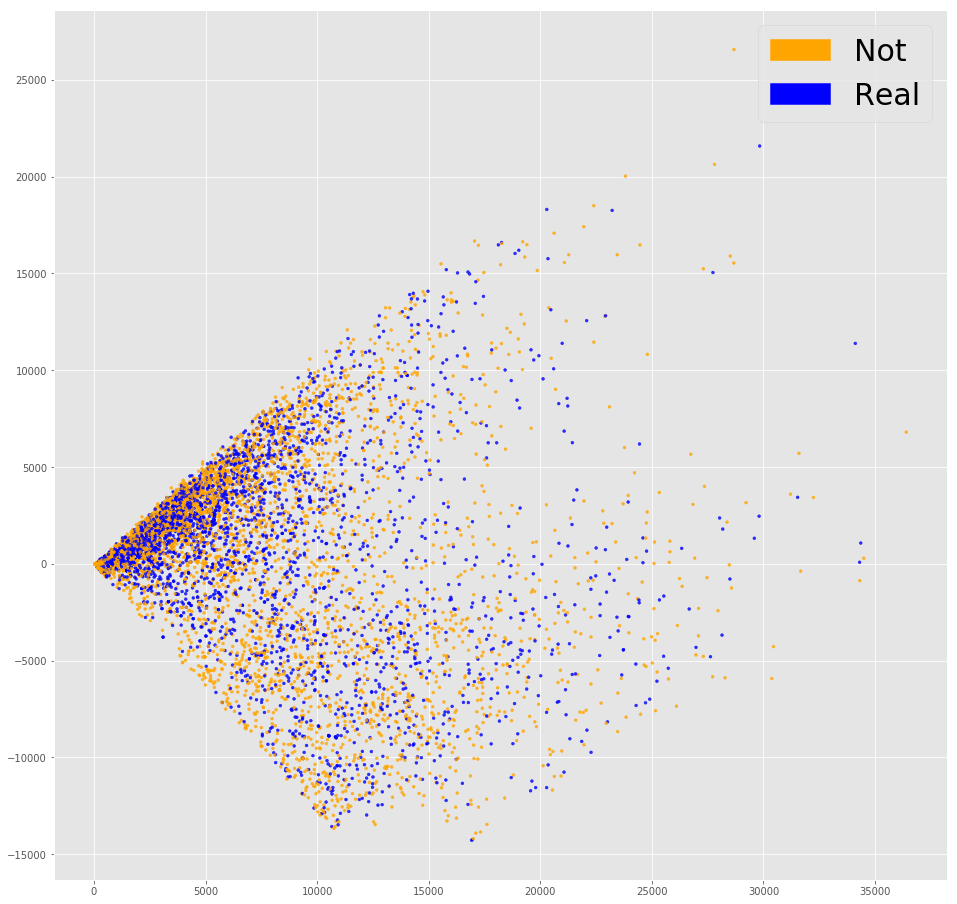

In [156]:
fig = plt.figure(figsize=(16,16))
plot_LSA(train_baseline,train['target'])
plt.show()

In [157]:
history = model.fit(X_train,y_train,batch_size=4,epochs=20,validation_data=(X_test,y_test),verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
 - 31s - loss: 0.5855 - accuracy: 0.7189 - mse: 0.1981 - val_loss: 0.5615 - val_accuracy: 0.7446 - val_mse: 0.1877
Epoch 2/20
 - 31s - loss: 0.5618 - accuracy: 0.7458 - mse: 0.1874 - val_loss: 0.5190 - val_accuracy: 0.7807 - val_mse: 0.1687
Epoch 3/20
 - 31s - loss: 0.5279 - accuracy: 0.7658 - mse: 0.1728 - val_loss: 0.4920 - val_accuracy: 0.7787 - val_mse: 0.1591
Epoch 4/20
 - 30s - loss: 0.5226 - accuracy: 0.7713 - mse: 0.1707 - val_loss: 0.4819 - val_accuracy: 0.7879 - val_mse: 0.1545
Epoch 5/20
 - 30s - loss: 0.5106 - accuracy: 0.7773 - mse: 0.1657 - val_loss: 0.4822 - val_accuracy: 0.7978 - val_mse: 0.1529
Epoch 6/20
 - 28s - loss: 0.5137 - accuracy: 0.7724 - mse: 0.1672 - val_loss: 0.5124 - val_accuracy: 0.8043 - val_mse: 0.1635
Epoch 7/20
 - 30s - loss: 0.4988 - accuracy: 0.7800 - mse: 0.1611 - val_loss: 0.4879 - val_accuracy: 0.7728 - val_mse: 0.1577
Epoch 8/20
 - 31s - loss: 0.4898 - accuracy: 0.7810 - mse: 0.1577 - va

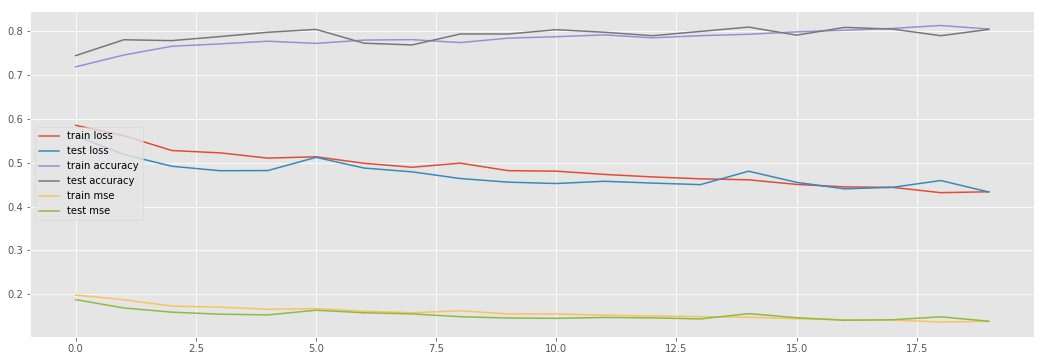

In [158]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='test loss')
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='test accuracy')
plt.plot(history.history['mse'],label='train mse')
plt.plot(history.history['val_mse'],label='test mse')
plt.legend()

In [159]:
model.save('nlp_disaster.h5')

In [160]:
train_pred_GloVe = model.predict(train_baseline)
train_pred_GloVe_int = train_pred_GloVe.round().astype('int')

In [161]:
test_pred_Glove = model.predict(test_baseline)
test_pred_GloVe_int = test_pred_Glove.round().astype('int')

In [162]:
Glove_df = pd.DataFrame(test_pred_GloVe_int,columns=['pred_Glove'])
Glove_df.head(10)

pred_Glove
0           1
1           1
2           1
3           1
4           1
5           1
6           0
7           0
8           0
9           0

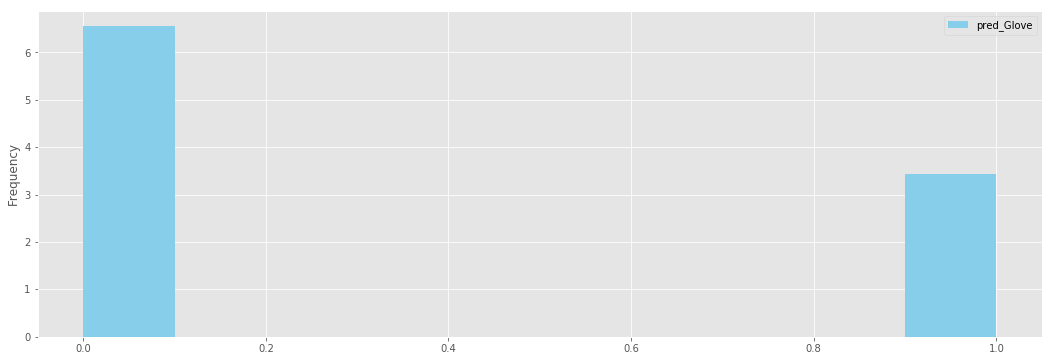

In [163]:
Glove_df.plot.hist(density=True,color='skyblue')

In [164]:
outputpath = 'C:/Users/zjx_n/Desktop/labs/NLP with disasters/nlp-getting-started/baseline_submission.csv'
Glove_df.to_csv(outputpath,index=True,header=True)

### Improved deep learning model(using LSTM)

In [165]:
import keras

from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Activation

from keras.layers import Conv2D, MaxPooling2D,Reshape

In [166]:
model_LSTM = Sequential()
embedding_layer1 = Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_LEN,trainable=False)

In [167]:
model_LSTM.add(embedding_layer1)
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(32,return_sequences=True))
model_LSTM.add(Dense(24, activation='relu'))

In [168]:
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(64,return_sequences=True))
model_LSTM.add(LSTM(32,return_sequences=True))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Flatten())
model_LSTM.add(Dense(1, activation='sigmoid'))

In [169]:
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1810400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 32)            17024     
_________________________________________________________________
dense_2 (Dense)              (None, 50, 24)            792       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 24)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 64)            22784     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 32)           

In [170]:
model_LSTM.compile(loss="binary_crossentropy", optimizer="adadelta",metrics=["accuracy","mse"])

In [171]:
history_LSTM = model_LSTM.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_test,y_test),verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
 - 8s - loss: 0.5541 - accuracy: 0.7250 - mse: 0.1860 - val_loss: 0.4607 - val_accuracy: 0.7932 - val_mse: 0.1486
Epoch 2/10
 - 8s - loss: 0.4645 - accuracy: 0.7874 - mse: 0.1502 - val_loss: 0.5575 - val_accuracy: 0.7538 - val_mse: 0.1800
Epoch 3/10
 - 8s - loss: 0.4491 - accuracy: 0.7984 - mse: 0.1442 - val_loss: 0.5549 - val_accuracy: 0.7354 - val_mse: 0.1858
Epoch 4/10
 - 7s - loss: 0.4373 - accuracy: 0.8057 - mse: 0.1399 - val_loss: 0.4384 - val_accuracy: 0.8070 - val_mse: 0.1400
Epoch 5/10
 - 7s - loss: 0.4272 - accuracy: 0.8071 - mse: 0.1363 - val_loss: 0.5323 - val_accuracy: 0.7649 - val_mse: 0.1712
Epoch 6/10
 - 7s - loss: 0.4162 - accuracy: 0.8197 - mse: 0.1322 - val_loss: 0.4442 - val_accuracy: 0.8116 - val_mse: 0.1406
Epoch 7/10
 - 7s - loss: 0.4183 - accuracy: 0.8141 - mse: 0.1332 - val_loss: 0.4664 - val_accuracy: 0.7958 - val_mse: 0.1499
Epoch 8/10
 - 7s - loss: 0.4087 - accuracy: 0.8179 - mse: 0.1294 - val_loss: 

In [172]:
def result_eva (loss,val_loss,acc,val_acc,mse,val_mse):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    epochs = range(1,len(loss)+1)
    plt.plot(epochs, loss,'b-o', label ='Training Loss')
    plt.plot(epochs, val_loss,'r-o', label ='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, "b-o", label="Training Acc")
    plt.plot(epochs, val_acc, "r-o", label="Validation Acc")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, mse, "b-o", label="Training MSE")
    plt.plot(epochs, val_acc, "r-o", label="Validation MSE")
    plt.title("Training and Validation MSE")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

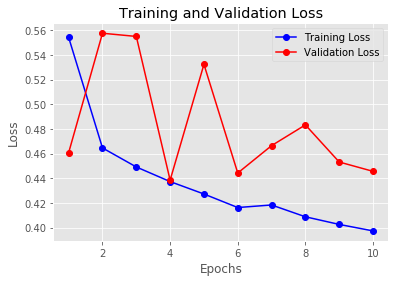

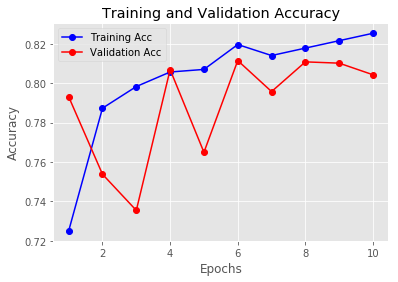

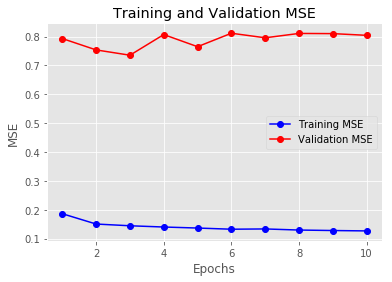

In [173]:
result_eva(history_LSTM.history['loss'], history_LSTM.history['val_loss'], history_LSTM.history['accuracy'], history_LSTM.history['val_accuracy'],history_LSTM.history['mse'], history_LSTM.history['val_mse'])

In [174]:
model_LSTM.save('nlp_disaster_lstm.h5')

In [175]:
train_pred_LSTM = model_LSTM.predict(train_baseline)
train_pred_LSTM_int = train_pred_LSTM.round().astype('int')

In [176]:
test_pred_LSTM = model_LSTM.predict(test_baseline)
test_pred_LSTM_int = test_pred_LSTM.round().astype('int')

In [177]:
LSTM_df = pd.DataFrame(test_pred_LSTM_int,columns=['pred_Glove'])
LSTM_df.head(10)

pred_Glove
0           1
1           1
2           1
3           1
4           1
5           1
6           0
7           0
8           0
9           0

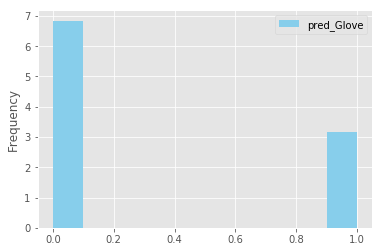

In [178]:
LSTM_df.plot.hist(density=True,color='skyblue')

In [179]:
outputpath = 'C:/Users/zjx_n/Desktop/labs/NLP with disasters/nlp-getting-started/lstm_submission.csv'
LSTM_df.to_csv(outputpath,index=True,header=True)